In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRFRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [45]:
# Load dataset
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [46]:
df_test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [47]:
#Shape
print(f"Train Shape: " + str(df_train.shape))
print(f"Test Shape: " + str(df_test.shape))

Train Shape: (1460, 81)
Test Shape: (1459, 80)


In [48]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [49]:
df_train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

/var/folders/89/wy7_qkjn4dz1y9trj8f2mmvw0000gn/T/ipykernel_27033/3841975554.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df_train.corr()


<AxesSubplot: >

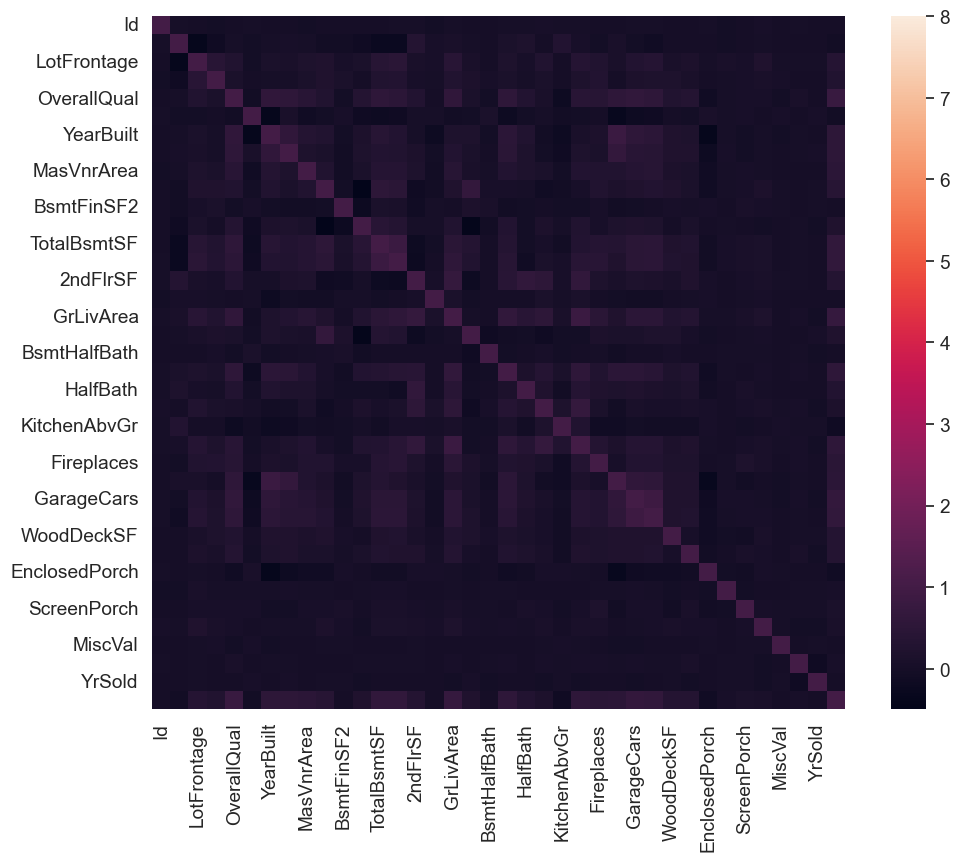

In [50]:
#Correlation matrix
corr = df_train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corr, vmax=8, square=True)

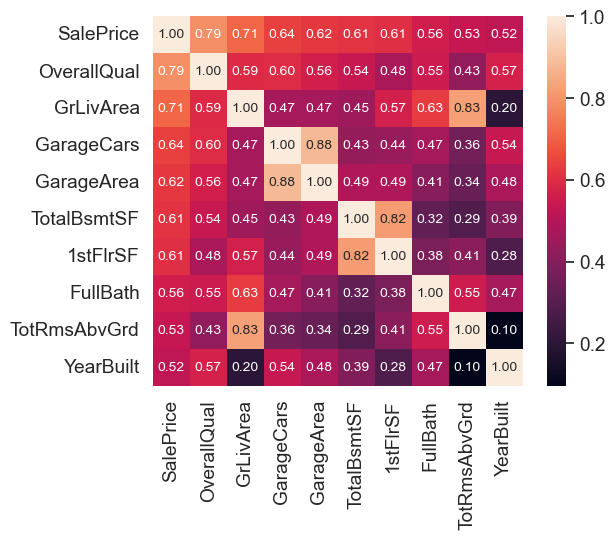

In [51]:
k = 10
cols = corr.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(df_train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values,
                 xticklabels=cols.values)
plt.show()

In [52]:
total = df_train.isnull().sum().sort_values(ascending=False)
percentage = (df_train.isnull().sum() / df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percentage], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageYrBlt,81,0.055479
GarageCond,81,0.055479
GarageType,81,0.055479
GarageFinish,81,0.055479


In [53]:
df_train = df_train.drop(labels=(missing_data[missing_data['Total'] > 1]).index, axis=1)

In [80]:
#Split dataset
X = df_train.drop(['SalePrice'], axis=1)
y = df_train['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [81]:
df_train = pd.get_dummies(df_train, drop_first=True)
df_test = pd.get_dummies(df_test, drop_first=True)

In [82]:
print(f"X_train: ", X_train.shape)
print(f"X_test", X_test.shape)
print(f"y_train", y_train.shape)
print(f"y_test", y_test.shape)
# ss = StandardScaler()
# X_train = ss.fit_transform(X_train)
# X_test = ss.fit(X_test)

X_train:  (1168, 193)
X_test (292, 193)
y_train (1168,)
y_test (292,)


In [85]:
rf = RandomForestRegressor(random_state=0)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
rf_r2 = r2_score(y_test, rf_pred)
rf_mae = mean_absolute_error(y_test, rf_pred)
rf_mse = mean_squared_error(y_test, rf_pred)
rf_rmse = np.sqrt(rf_mse)
print(f"R2: ", rf_r2)
print(f"MAE: ", rf_mae)
print(f"MSE: ", rf_mse)
print(f"RMSE: ", rf_rmse)

R2:  0.8957223893723131
MAE:  17189.12821917808
MSE:  597872996.3477348
RMSE:  24451.44160060373


In [94]:
rfr_results = pd.DataFrame([['Random Forest Regressor', rf_r2, rf_mae, rf_mse, rf_rmse]],
                           columns=['Model', 'R-squared (R²)', 'Mean Absolute Error', 'Mean Squared Error', 'Root Mean Squared Error'])
rfr_results

,Model,R-squared (R²),Mean Absolute Error,Mean Squared Error,Root Mean Squared Error
0,Random Forest Regressor,0.895722,17189.128219,5.978730e+08,24451.441601


In [99]:
#XGBoost
model = XGBRFRegressor()
model.fit(X_train, y_train, verbose=False)
predictions = model.predict(X_test)

xgb_r2 = r2_score(y_test, predictions)
xgb_mae = mean_absolute_error(y_test, predictions)
xgb_mse = mean_squared_error(y_test, predictions)
xgb_rmse = np.sqrt(rf_mse)
print(f"R2: ", xgb_r2)
print(f"MAE: ", xgb_mae)
print(f"MSE: ", xgb_mse)
print(f"RMSE: ", xgb_rmse)

R2:  0.8713506141847018
MAE:  19646.77052119007
MSE:  737607942.0376171
RMSE:  24451.44160060373
